In [1]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime
from scipy import signal
from scipy.signal import savgol_filter
from PIL import Image

In [3]:
class BorderCatcher:

    def __init__(self, corners, width, height, shift):
        self.corners = corners
        self.width = width
        self.height = height
        self.shift = shift

    def predict(self, path, prefix, visualization=False):
        # 1. Get images
        names = self._get_images(path)
        if len(names) == 0:
            return [], []
        
        # 2. Get borders
        images = []
        curves = []
        borders = []
        for name in names:
            image, curve, border = self._get_border(path, name)
            images.append(image)
            curves.append(curve)
            borders.append(border)
        
        # 3. Smoothing borders
        borders = [int(border) for border in self._border_filter(borders)]

        # 4. Get timeline
        minutes = self._get_minutes(names)

        # 5. Save images
        if visualization:
            for i, name in enumerate(names):
                image = images[i]
                curve = curves[i]
                border = borders[i]
                minute = minutes[i]
                self._save_image(image, path, prefix, name, minute, curve, border)
            # create gif
            self._make_gif(path + prefix + '/', names[0][:-4] + '.gif')
        borders = [int((1 - round(border/self.height, 3)) * 100) for border in borders]
        return borders, minutes

         
    def _get_images(self, path):
        '''
        Get all .png pictures in folder 'path'
        '''
        names_list = glob.glob(f"{path}/*.png")
        names_list.sort()
        try:
            names_list = names_list[1:]
            names_list = [name.split('/')[-1] for name in names_list]
        except:
            pass
        return names_list

    def _get_border(self, path, name):
        '''
        Find border. Return warped image, cumulative V-channel from HSV for light-curve, and border
        '''
        # read
        image = cv2.imread(path + name)
        # warp
        image = self._warp_image(image)
        # get V-channel
        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_hsv = image_hsv[:, :, 2]
        # get source curve
        arr = [sum(layer) for layer in image_hsv]
        arr = list((arr - np.min(arr)) / np.ptp(arr))     
        curve = [int(x * self.width) for x in arr]
        # find border
        filtered = savgol_filter(arr, 51, 2, 0, mode='interp')
        delta_arr = [filtered[i] - filtered[i + self.shift] for i in range(len(filtered) - self.shift)]
        delta_max = max(delta_arr)
        border = delta_arr.index(delta_max) + int(self.shift / 2)
        return image, curve, border

    def _warp_image(self, image):
        '''
        Resize to 960x640 and warp for 4 points q1...q4 to width X height
        '''
        image = cv2.resize(image, (960, 640), interpolation = cv2.INTER_AREA)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

        q1, q2, q3, q4 = self.corners
        
        input = np.float32([q1, q2, q3, q4])
        output = np.float32([
            [0, 0],
            [self.width - 1, 0],
            [self.width - 1, self.height - 1],
            [0, self.height - 1]
        ])

        matrix = cv2.getPerspectiveTransform(input, output)

        image = cv2.warpPerspective(
            image,
            matrix,
            (self.width, self.height),
            cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0,0,0)
        )
        return image

    def _border_filter(self, borders):
        '''
        Smoothing borders
        '''
        b, a = signal.butter(6, 0.2, btype='lowpass', analog=False)
        return signal.filtfilt(b, a, borders)

    def _get_minutes(self, names):
        '''
        Get minutes from start
        '''
        start = datetime.strptime(names[0][6:-4], '%Y-%m-%d_%H-%M-%S')
        return [round((datetime.strptime(name[6:-4], '%Y-%m-%d_%H-%M-%S') - start).seconds / 60, 1) for name in names]

    def _save_image(self, image, path, prefix, name, minute, curve, border):
        '''
        Save cropped and warped images with additional information
        '''
        for y in range(height):
            image = cv2.circle(image, [curve[y],  y], 1, (0, 0, 255), -1)

        image = cv2.line(image, [0, border], [self.width, border], (0, 255, 0), thickness=1)

        self._add_text(image, str(int((1 - round(border/self.height, 3)) * 100)) + ' %', 50, 100)

        self._add_text(image, str(minute) + ' min.', 50, 200)

        try:
            os.mkdir(path + prefix)
        except:
            pass
        cv2.imwrite(os.path.join(path + prefix + '/', prefix + '_' + name + '.jpg'), image)

    def _make_gif(self, path, name):
        '''
        Create GIF from prepreocessing images
        '''
        names_list = glob.glob(f"{path}/*.jpg")
        names_list.sort()
        frames = [Image.open(image) for image in names_list]
        frame_one = frames[0]
        frame_one.save(path + '/' + name, format="GIF", append_images=frames,
                save_all=True, duration=500, loop=0)
        
    def _add_text(self, image, text, x, y):
        '''
        Add text to image to (x, y) coordinates
        '''
        font = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (x, y)
        fontScale = 2
        fontColor = (255,0,0)
        thickness = 2
        lineType = 2

        cv2.putText(
            image,
            text, 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            thickness,
            lineType
            )

In [4]:
# corners for cut and warp
corners = [285,143], [490,150], [546,806], [305,810]

# result image parameters
width = 400
height = 800

# algotirhm parameter for border smoothing
shift = 20

# folder with images
path = '/drive/MyDrive/ml/boundary/src/photo_experiment_2022-09-10_11-45-10/'
# subfolder name for results
prefix = 'outcome'

# initialization
catcher = BorderCatcher(corners, width, height, shift)

# calculation
borders, minutes = catcher.predict(path, prefix, True)

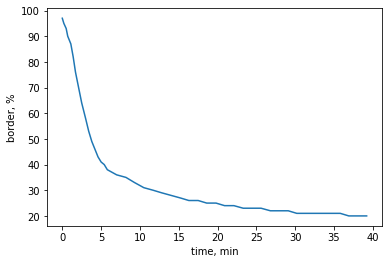

In [5]:
from matplotlib import pyplot as plt
plt.plot(minutes, borders)
plt.ylabel('border, %')
plt.xlabel('time, min')
plt.show()